# MLIKH Model: Steady-State Flow Curves

## Learning Objectives

1. Fit the **MLIKH (Multi-Lambda IKH)** model to steady-state flow curve data
2. Understand **multi-mode thixotropy** with distributed timescales
3. Compare **per_mode** vs **weighted_sum** yield formulations
4. Analyze how multiple modes capture complex flow behavior
5. Calibrate parameters for downstream synthetic data generation

## Prerequisites

- NB01-06: MIKH tutorials (single-mode understanding)

## Runtime

- Fast demo (NUM_CHAINS=1, NUM_SAMPLES=500): ~3-4 minutes
- Full run (NUM_CHAINS=4, NUM_SAMPLES=2000): ~15-20 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.ikh import MLIKH

# Add examples/utils to path for tutorial utilities
sys.path.insert(0, os.path.join("..", "utils"))
from ikh_tutorial_utils import (
    load_ml_ikh_flow_curve,
    save_ikh_results,
    print_convergence_summary,
    print_parameter_comparison,
    compute_fit_quality,
    get_mlikh_param_names,
)

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: Multi-Mode IKH

The **MLIKH (Multi-Lambda IKH)** model extends MIKH to N modes connected in parallel, capturing **distributed thixotropic timescales**.

### Motivation

Real materials often exhibit:
- Multiple restructuring timescales
- Broad relaxation spectra
- Complex flow history dependence

### Two Yield Formulations

**1. Per-Mode Yield** (default):
- Each mode has independent yield surface
- Total stress = $\sum_i \sigma_i$ (parallel connection)
- Parameters: 7 per mode + 1 global

**2. Weighted-Sum Yield**:
- Single global yield surface: $\sigma_y = \sigma_{y0} + k_3 \sum_i w_i \lambda_i$
- All modes share elastic/plastic response
- Parameters: 5 global + 3 per mode

### Per-Mode Parameters (for each mode $i$)

| Parameter | Symbol | Description |
|-----------|--------|-------------|
| `G_i` | $G_i$ | Mode shear modulus (Pa) |
| `C_i` | $C_i$ | Kinematic hardening modulus (Pa) |
| `gamma_dyn_i` | $\gamma_{dyn,i}$ | Dynamic recovery |
| `sigma_y0_i` | $\sigma_{y0,i}$ | Minimal yield stress (Pa) |
| `delta_sigma_y_i` | $\Delta\sigma_{y,i}$ | Structural yield contribution (Pa) |
| `tau_thix_i` | $\tau_{thix,i}$ | Thixotropic timescale (s) |
| `Gamma_i` | $\Gamma_i$ | Breakdown coefficient |

### Key Physics

- **Distributed timescales**: Different modes restructure at different rates
- **Parallel stress**: Total stress is sum of mode contributions
- **Independent yielding**: Each mode can yield independently (per_mode)

## 3. Load Data

In [3]:
# Load flow curve data (same as MIKH NB01)
gamma_dot, stress = load_ml_ikh_flow_curve(instrument="ARES_up")

print(f"Data points: {len(gamma_dot)}")
print(f"Shear rate range: [{gamma_dot.min():.4f}, {gamma_dot.max():.2f}] 1/s")
print(f"Stress range: [{stress.min():.2f}, {stress.max():.2f}] Pa")

Data points: 21
Shear rate range: [0.0100, 100.00] 1/s
Stress range: [0.75, 51.46] Pa


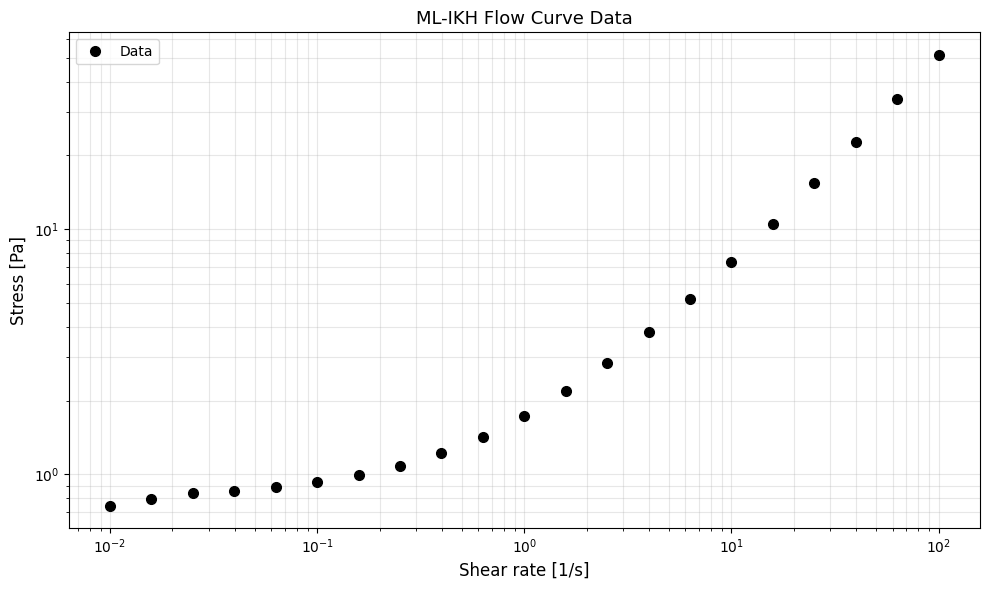

In [4]:
# Plot raw data
fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(gamma_dot, stress, "ko", markersize=7, label="Data")
ax.set_xlabel("Shear rate [1/s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title("ML-IKH Flow Curve Data", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

### 4.1 Per-Mode Yield (2 modes)

In [5]:
# Create MLIKH model with 2 modes, per_mode yield
n_modes = 2
model_per_mode = MLIKH(n_modes=n_modes, yield_mode="per_mode")
param_names_pm = get_mlikh_param_names(n_modes=n_modes, yield_mode="per_mode")

print(f"MLIKH (per_mode, {n_modes} modes): {len(param_names_pm)} parameters")
print(f"Parameters: {param_names_pm}")

MLIKH (per_mode, 2 modes): 15 parameters
Parameters: ['G_1', 'C_1', 'gamma_dyn_1', 'sigma_y0_1', 'delta_sigma_y_1', 'tau_thix_1', 'Gamma_1', 'G_2', 'C_2', 'gamma_dyn_2', 'sigma_y0_2', 'delta_sigma_y_2', 'tau_thix_2', 'Gamma_2', 'eta_inf']


In [6]:
# Fit model
t0 = time.time()
model_per_mode.fit(gamma_dot, stress, test_mode="flow_curve")
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters (per-mode):")
for name in param_names_pm:
    val = model_per_mode.parameters.get_value(name)
    print(f"  {name:18s} = {val:.4g}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=15 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=3.839890s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=4.1340 | elapsed=3.840s | final_gradient_norm=1.0150e-06


NLSQ fit time: 4.47 s

Fitted parameters (per-mode):
  G_1                = 500
  C_1                = 3822
  gamma_dyn_1        = 4323
  sigma_y0_1         = 0.6641
  delta_sigma_y_1    = 1.108e-05
  tau_thix_1         = 1.269e+09
  Gamma_1            = 9954
  G_2                = 500.3
  C_2                = 250
  gamma_dyn_2        = 1.013
  sigma_y0_2         = 0.6641
  delta_sigma_y_2    = 3.188e-05
  tau_thix_2         = 2.547e+09
  Gamma_2            = 9941
  eta_inf            = 0.513


In [7]:
# Compute fit quality
stress_pred_pm = model_per_mode.predict_flow_curve(gamma_dot)
metrics_pm = compute_fit_quality(stress, stress_pred_pm)

print(f"\nFit Quality (per_mode):")
print(f"  R^2:   {metrics_pm['R2']:.6f}")
print(f"  RMSE:  {metrics_pm['RMSE']:.4g} Pa")


Fit Quality (per_mode):
  R^2:   0.997611
  RMSE:  0.6275 Pa


### 4.2 Weighted-Sum Yield (2 modes)

In [8]:
# Create MLIKH model with weighted_sum yield
model_weighted_sum = MLIKH(n_modes=n_modes, yield_mode="weighted_sum")
param_names_ws = get_mlikh_param_names(n_modes=n_modes, yield_mode="weighted_sum")

print(f"MLIKH (weighted_sum, {n_modes} modes): {len(param_names_ws)} parameters")
print(f"Parameters: {param_names_ws}")

MLIKH (weighted_sum, 2 modes): 11 parameters
Parameters: ['G', 'C', 'gamma_dyn', 'sigma_y0', 'k3', 'tau_thix_1', 'Gamma_1', 'w_1', 'tau_thix_2', 'Gamma_2', 'w_2']


In [9]:
# Fit model
t0 = time.time()
model_weighted_sum.fit(gamma_dot, stress, test_mode="flow_curve")
t_nlsq_ws = time.time() - t0

print(f"NLSQ fit time: {t_nlsq_ws:.2f} s")

# Compute fit quality
stress_pred_ws = model_weighted_sum.predict_flow_curve(gamma_dot)
metrics_ws = compute_fit_quality(stress, stress_pred_ws)

print(f"\nFit Quality (weighted_sum):")
print(f"  R^2:   {metrics_ws['R2']:.6f}")
print(f"  RMSE:  {metrics_ws['RMSE']:.4g} Pa")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=13 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=3.272267s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=20 | final_cost=4.1340 | elapsed=3.272s | final_gradient_norm=0.0019


NLSQ fit time: 3.80 s

Fit Quality (weighted_sum):
  R^2:   0.997611
  RMSE:  0.6275 Pa


### 4.3 Compare Yield Formulations

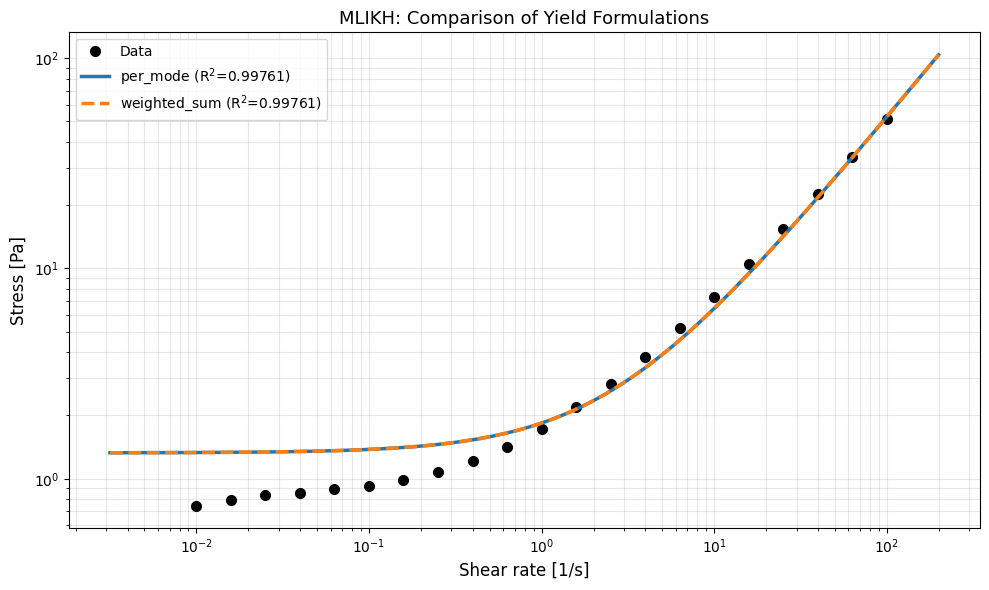

In [10]:
# Plot comparison
gamma_dot_fine = np.logspace(
    np.log10(gamma_dot.min()) - 0.5,
    np.log10(gamma_dot.max()) + 0.3,
    200,
)
stress_pm_fine = model_per_mode.predict_flow_curve(gamma_dot_fine)
stress_ws_fine = model_weighted_sum.predict_flow_curve(gamma_dot_fine)

fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(gamma_dot, stress, "ko", markersize=7, label="Data")
ax.loglog(gamma_dot_fine, stress_pm_fine, "-", lw=2.5, color="C0", 
          label=f"per_mode (R$^2$={metrics_pm['R2']:.5f})")
ax.loglog(gamma_dot_fine, stress_ws_fine, "--", lw=2.5, color="C1", 
          label=f"weighted_sum (R$^2$={metrics_ws['R2']:.5f})")

ax.set_xlabel("Shear rate [1/s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title("MLIKH: Comparison of Yield Formulations", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

### 4.4 Mode Contribution Analysis

In [11]:
# Analyze per-mode contributions (for per_mode model)
print("Mode Contributions (per_mode formulation):")
print("=" * 50)

for i in range(1, n_modes + 1):
    G_i = model_per_mode.parameters.get_value(f"G_{i}")
    sigma_y0_i = model_per_mode.parameters.get_value(f"sigma_y0_{i}")
    delta_sigma_y_i = model_per_mode.parameters.get_value(f"delta_sigma_y_{i}")
    tau_thix_i = model_per_mode.parameters.get_value(f"tau_thix_{i}")
    Gamma_i = model_per_mode.parameters.get_value(f"Gamma_{i}")
    
    print(f"\nMode {i}:")
    print(f"  G_{i} = {G_i:.3g} Pa")
    print(f"  sigma_y0_{i} = {sigma_y0_i:.3g} Pa")
    print(f"  delta_sigma_y_{i} = {delta_sigma_y_i:.3g} Pa")
    print(f"  tau_thix_{i} = {tau_thix_i:.3g} s")
    print(f"  Gamma_{i} = {Gamma_i:.4g}")

Mode Contributions (per_mode formulation):

Mode 1:
  G_1 = 500 Pa
  sigma_y0_1 = 0.664 Pa
  delta_sigma_y_1 = 1.11e-05 Pa
  tau_thix_1 = 1.27e+09 s
  Gamma_1 = 9954

Mode 2:
  G_2 = 500 Pa
  sigma_y0_2 = 0.664 Pa
  delta_sigma_y_2 = 3.19e-05 Pa
  tau_thix_2 = 2.55e+09 s
  Gamma_2 = 9941


## 5. Bayesian Inference with NUTS

In [12]:
# Use per_mode model for Bayesian inference
model = model_per_mode
param_names = param_names_pm

initial_values = {
    name: model.parameters.get_value(name)
    for name in param_names
}

# Fast demo config
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1

print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
t0 = time.time()
result = model.fit_bayesian(
    gamma_dot,
    stress,
    test_mode="flow_curve",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Running NUTS: 200 warmup + 500 samples x 1 chain(s)


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:02<27:49,  2.39s/it, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   1%|          | 7/700 [00:02<03:05,  3.73it/s, 1023 steps of size 1.06e-03. acc. prob=0.57]

warmup:   2%|▏         | 12/700 [00:02<01:37,  7.03it/s, 1023 steps of size 1.11e-03. acc. prob=0.75]

warmup:   2%|▏         | 16/700 [00:02<01:09,  9.90it/s, 1023 steps of size 1.50e-03. acc. prob=0.81]

warmup:   3%|▎         | 20/700 [00:02<00:51, 13.14it/s, 1023 steps of size 2.21e-03. acc. prob=0.85]

warmup:   3%|▎         | 24/700 [00:03<00:49, 13.55it/s, 1023 steps of size 3.19e-03. acc. prob=0.87]

warmup:   4%|▍         | 27/700 [00:03<00:43, 15.41it/s, 1023 steps of size 3.50e-03. acc. prob=0.89]

warmup:   4%|▍         | 30/700 [00:03<00:44, 15.10it/s, 1023 steps of size 4.58e-03. acc. prob=0.90]

warmup:   5%|▍         | 33/700 [00:03<00:41, 16.23it/s, 1023 steps of size 5.52e-03. acc. prob=0.90]

warmup:   5%|▌         | 36/700 [00:03<00:44, 15.06it/s, 1023 steps of size 6.30e-03. acc. prob=0.91]

warmup:   6%|▌         | 40/700 [00:03<00:35, 18.76it/s, 1023 steps of size 6.83e-03. acc. prob=0.92]

warmup:   6%|▌         | 43/700 [00:04<00:38, 17.12it/s, 1023 steps of size 8.24e-03. acc. prob=0.92]

warmup:   7%|▋         | 46/700 [00:04<00:33, 19.38it/s, 1023 steps of size 9.98e-03. acc. prob=0.93]

warmup:   7%|▋         | 50/700 [00:04<00:28, 23.03it/s, 1023 steps of size 9.57e-03. acc. prob=0.93]

warmup:   8%|▊         | 54/700 [00:04<00:25, 25.11it/s, 1023 steps of size 3.78e-03. acc. prob=0.93]

warmup:   8%|▊         | 58/700 [00:04<00:23, 27.29it/s, 1023 steps of size 4.71e-03. acc. prob=0.93]

warmup:   9%|▉         | 62/700 [00:04<00:21, 29.17it/s, 1023 steps of size 5.80e-03. acc. prob=0.94]

warmup:  10%|▉         | 67/700 [00:04<00:19, 32.53it/s, 1023 steps of size 6.93e-03. acc. prob=0.94]

warmup:  10%|█         | 71/700 [00:05<00:19, 33.03it/s, 1023 steps of size 7.18e-03. acc. prob=0.94]

warmup:  11%|█         | 75/700 [00:05<00:18, 34.35it/s, 1023 steps of size 8.11e-03. acc. prob=0.94]

warmup:  11%|█▏        | 80/700 [00:05<00:16, 37.29it/s, 511 steps of size 9.58e-03. acc. prob=0.95] 

warmup:  12%|█▏        | 86/700 [00:05<00:14, 40.96it/s, 1023 steps of size 8.98e-03. acc. prob=0.95]

warmup:  13%|█▎        | 91/700 [00:05<00:16, 36.23it/s, 1023 steps of size 6.78e-03. acc. prob=0.95]

warmup:  14%|█▎        | 95/700 [00:05<00:16, 37.10it/s, 1023 steps of size 6.75e-03. acc. prob=0.95]

warmup:  14%|█▍        | 99/700 [00:05<00:16, 36.39it/s, 511 steps of size 7.78e-03. acc. prob=0.95] 

warmup:  17%|█▋        | 118/700 [00:05<00:07, 75.12it/s, 127 steps of size 4.10e-02. acc. prob=0.95]

warmup:  20%|██        | 140/700 [00:05<00:04, 113.33it/s, 127 steps of size 3.98e-02. acc. prob=0.96]

warmup:  23%|██▎       | 162/700 [00:06<00:03, 142.61it/s, 127 steps of size 2.63e-02. acc. prob=0.96]

warmup:  26%|██▌       | 181/700 [00:06<00:03, 155.59it/s, 63 steps of size 5.53e-02. acc. prob=0.96] 

sample:  30%|███       | 211/700 [00:06<00:02, 195.46it/s, 63 steps of size 5.57e-02. acc. prob=0.99]

sample:  33%|███▎      | 232/700 [00:06<00:02, 181.74it/s, 63 steps of size 5.57e-02. acc. prob=0.99]

sample:  36%|███▌      | 252/700 [00:06<00:02, 184.68it/s, 127 steps of size 5.57e-02. acc. prob=0.99]

sample:  39%|███▉      | 273/700 [00:06<00:02, 190.97it/s, 63 steps of size 5.57e-02. acc. prob=0.99] 

sample:  42%|████▏     | 293/700 [00:06<00:02, 190.46it/s, 63 steps of size 5.57e-02. acc. prob=0.99]

sample:  45%|████▍     | 313/700 [00:06<00:02, 190.06it/s, 63 steps of size 5.57e-02. acc. prob=0.99]

sample:  48%|████▊     | 338/700 [00:06<00:01, 205.41it/s, 127 steps of size 5.57e-02. acc. prob=0.99]

sample:  51%|█████▏    | 359/700 [00:07<00:01, 205.92it/s, 63 steps of size 5.57e-02. acc. prob=0.99] 

sample:  54%|█████▍    | 380/700 [00:07<00:01, 199.01it/s, 63 steps of size 5.57e-02. acc. prob=0.99]

sample:  57%|█████▋    | 401/700 [00:07<00:01, 194.38it/s, 63 steps of size 5.57e-02. acc. prob=0.99]

sample:  61%|██████    | 424/700 [00:07<00:01, 202.47it/s, 63 steps of size 5.57e-02. acc. prob=0.99]

sample:  64%|██████▎   | 445/700 [00:07<00:01, 195.39it/s, 63 steps of size 5.57e-02. acc. prob=0.99]

sample:  67%|██████▋   | 470/700 [00:07<00:01, 209.03it/s, 63 steps of size 5.57e-02. acc. prob=0.99]

sample:  71%|███████   | 496/700 [00:07<00:00, 222.35it/s, 63 steps of size 5.57e-02. acc. prob=0.99]

sample:  74%|███████▍  | 519/700 [00:07<00:00, 219.95it/s, 63 steps of size 5.57e-02. acc. prob=0.99]

sample:  77%|███████▋  | 542/700 [00:07<00:00, 221.82it/s, 63 steps of size 5.57e-02. acc. prob=0.99]

sample:  81%|████████  | 565/700 [00:07<00:00, 215.51it/s, 63 steps of size 5.57e-02. acc. prob=0.99]

sample:  84%|████████▍ | 587/700 [00:08<00:00, 208.22it/s, 63 steps of size 5.57e-02. acc. prob=0.99]

sample:  88%|████████▊ | 615/700 [00:08<00:00, 227.50it/s, 63 steps of size 5.57e-02. acc. prob=0.99]

sample:  91%|█████████ | 638/700 [00:08<00:00, 218.85it/s, 63 steps of size 5.57e-02. acc. prob=0.99]

sample:  94%|█████████▍| 661/700 [00:08<00:00, 196.95it/s, 63 steps of size 5.57e-02. acc. prob=0.99]

sample:  97%|█████████▋| 682/700 [00:08<00:00, 182.30it/s, 63 steps of size 5.57e-02. acc. prob=0.99]

sample: 100%|██████████| 700/700 [00:08<00:00, 80.44it/s, 63 steps of size 5.57e-02. acc. prob=0.99] 


Bayesian inference time: 14.0 s


In [13]:
# Convergence diagnostics
all_pass = print_convergence_summary(result, param_names)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
            G_1    1.0000       500      PASS
            C_1    1.0000       500      PASS
    gamma_dyn_1    1.0000       500      PASS
     sigma_y0_1    1.0000       500      PASS
delta_sigma_y_1    1.0000       500      PASS
     tau_thix_1    1.0000       500      PASS
        Gamma_1    1.0000       500      PASS
            G_2    1.0000       500      PASS
            C_2    1.0000       500      PASS
    gamma_dyn_2    1.0000       500      PASS
     sigma_y0_2    1.0000       500      PASS
delta_sigma_y_2    1.0000       500      PASS
     tau_thix_2    1.0000       500      PASS
        Gamma_2    1.0000       500      PASS
        eta_inf    1.0000       500      PASS

Divergences: 0

All convergence criteria PASSED


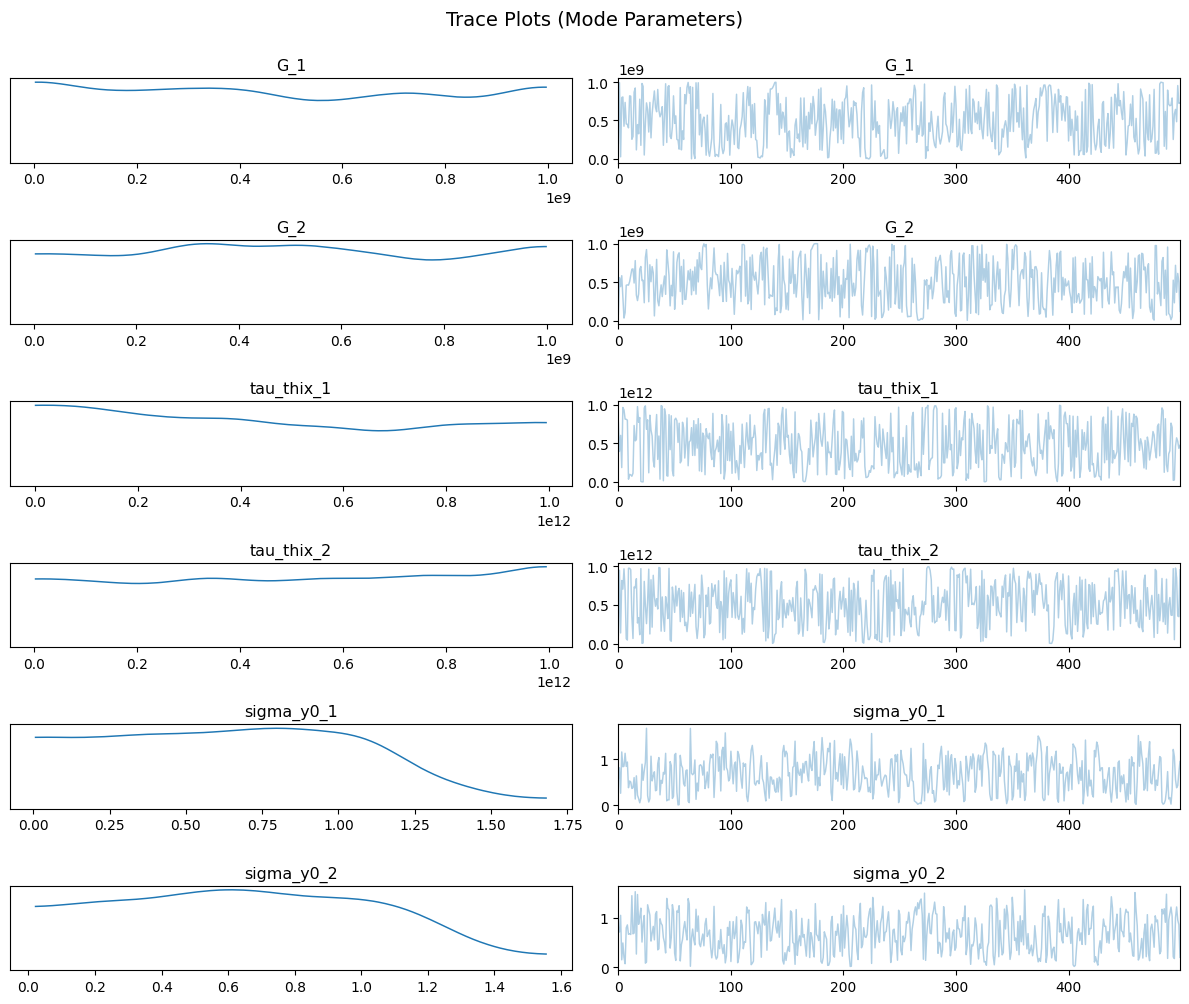

In [14]:
# Trace plots for key mode parameters
idata = result.to_inference_data()
mode_params = ["G_1", "G_2", "tau_thix_1", "tau_thix_2", "sigma_y0_1", "sigma_y0_2"]
axes = az.plot_trace(idata, var_names=mode_params, figsize=(12, 10))
fig = axes.ravel()[0].figure
fig.suptitle("Trace Plots (Mode Parameters)", fontsize=14, y=1.00)
plt.tight_layout()
display(fig)
plt.close(fig)

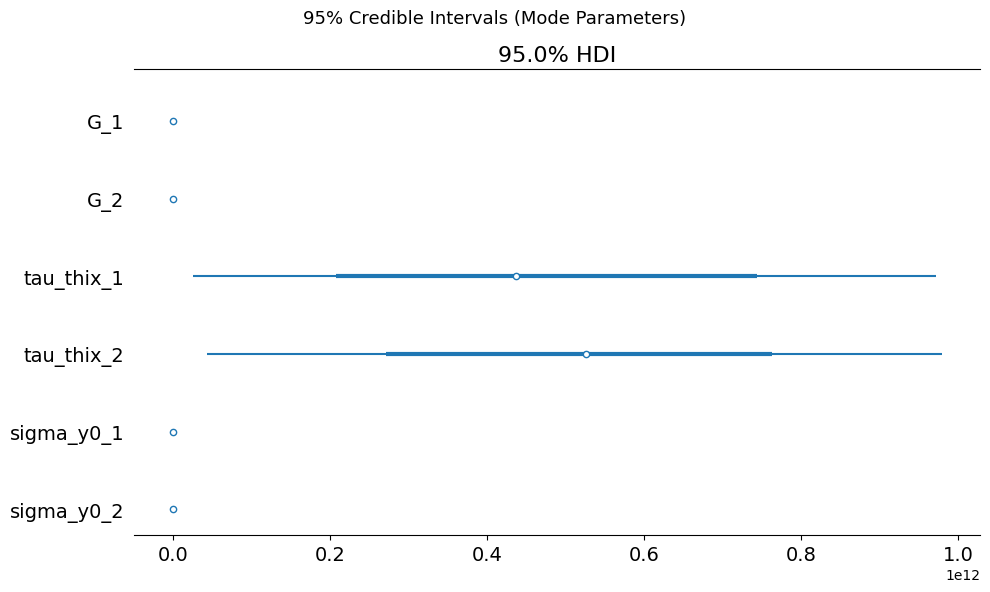

In [15]:
# Forest plot
axes = az.plot_forest(
    idata,
    var_names=mode_params,
    combined=True,
    hdi_prob=0.95,
    figsize=(10, 6),
)
fig = axes.ravel()[0].figure
fig.suptitle("95% Credible Intervals (Mode Parameters)", fontsize=13)
plt.tight_layout()
display(fig)
plt.close(fig)

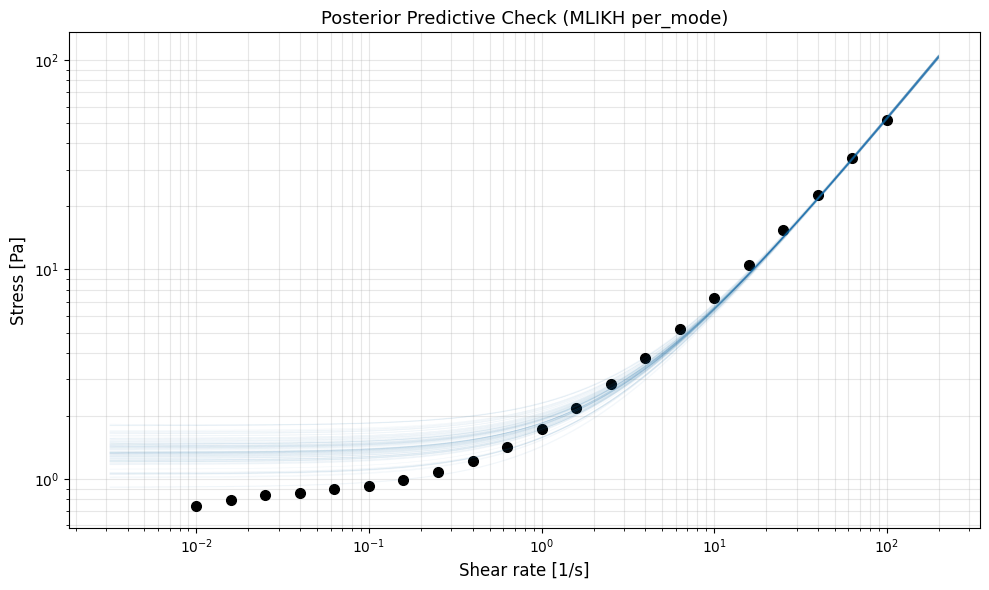

In [16]:
# Posterior predictive
posterior = result.posterior_samples
n_draws = min(100, len(list(posterior.values())[0]))

fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(gamma_dot, stress, "ko", markersize=7, label="Data")

# Plot posterior samples
for i in range(n_draws):
    params_i = jnp.array([posterior[name][i] for name in param_names])
    pred_i = model.model_function(jnp.array(gamma_dot_fine), params_i, test_mode="flow_curve")
    ax.loglog(gamma_dot_fine, pred_i, "-", color="C0", alpha=0.05, lw=0.5)

ax.set_xlabel("Shear rate [1/s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title("Posterior Predictive Check (MLIKH per_mode)", fontsize=13)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Physical Interpretation

### Multi-Mode Benefits

1. **Distributed timescales**: Modes with different $\tau_{thix,i}$ capture multiple restructuring rates
2. **Flexible yield**: Per-mode allows different yield stresses for different structural components
3. **Complex flow curves**: Captures inflections and subtle curvature in data

### Mode Identification

- **Fast mode** (small $\tau_{thix}$): Responds quickly, dominates high-rate behavior
- **Slow mode** (large $\tau_{thix}$): Responds slowly, dominates low-rate behavior

### Per-Mode vs Weighted-Sum

- **Per-mode**: More flexible, each mode contributes independently
- **Weighted-sum**: More constrained, single yield surface with structure contribution

## 7. Save Results

In [17]:
# Save results for downstream notebooks
save_ikh_results(model, result, "mlikh", "flow_curve", param_names)

print("\nParameters saved for synthetic data generation in:")
print("  - NB09: Stress Relaxation")
print("  - NB11: SAOS")

Results saved to /Users/b80985/Projects/rheojax/examples/ikh/../utils/../outputs/ikh/mlikh/flow_curve/
  nlsq_params_flow_curve.json: 15 parameters
  posterior_flow_curve.json: 500 draws

Parameters saved for synthetic data generation in:
  - NB09: Stress Relaxation
  - NB11: SAOS


## Key Takeaways

1. **MLIKH extends MIKH** to N modes with distributed thixotropic timescales

2. **Two yield formulations**:
   - **per_mode**: Independent yield surfaces, more flexible
   - **weighted_sum**: Single global yield, more constrained

3. **Parameter count**: 7N + 1 (per_mode) vs 5 + 3N (weighted_sum)

4. **Mode identification**: Different modes capture fast vs slow restructuring

5. **Multi-mode benefit**: Captures complex flow behavior that single-mode cannot

6. **Bayesian inference**: More challenging with more parameters, but NLSQ warm-start helps

### Next Steps

- **NB08**: MLIKH Startup (richer overshoot dynamics)
- **NB09**: MLIKH Relaxation (multi-mode decay)
- **NB10**: MLIKH Creep
- **NB11**: MLIKH SAOS (broadened spectra)
- **NB12**: MLIKH LAOS